# Trabalho Final NLP


## Nome: Guilherme Cramer Barbosa Silva

## Matrícula: 2021666152

Link para vídeo e dataset: https://drive.google.com/drive/folders/1oaIWDzafQ5hoWsNK5lAy8TptTwsUoH4H?usp=sharing

github do projeto: https://github.com/gcramerb/NLP

## Introdução:

O trabalho proposto visa resolver o problema chamado "textual entailment". Esse problema consiste em dado duas sentenças, falar se elas se contradizem, se uma implica a outra ou se são neutras entre si. Esse é um problema muito relevante no contexto de Processamento natural de linguagem. 

Esse problema aparece em cenários muito importantes. Por exemplo, em um contexto de contrato é importante que o texto não tenha incongruências. Essa tarefa é comumente usada como parte de uma aplicação maior. Como por exemplo análise de perguntas e respostas, sumarização de textos extração de informação. 

Esse é um problema muito desafiador, principalmente pelo fato do texto em sua forma de linguagem, contém uma ambiguidade intrínseca ao mesmo. Essa ambuiguidade faz com que seja difícil afirmar se uma sentença implica na outra ou se são opostas. Uma implicação desse fato é que até mesmo o ser humano não consegue executar essa tarefa com perfeição.  

Esse trabalho será dividido da seguinte forma: Na Seção dataset será explicado qual dataset foi usado e como foi feito o seu processamento. Já na Seção Metodologia será explicado o modelo usado e os seus hiperparâmetros, bem como a justificativa das escolhas dele. Na Seção experimentos será explicado como executar o código e quais os experimentos feitos para analisar o desempenho do modelo. Por fim, na conclusão será feita uma análise dos resultados e uma discussão do método proposto com o estado da arte. 


In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt     
from matplotlib.pyplot import figure
import pandas as pd
import os,pickle
from sklearn.metrics import confusion_matrix,accuracy_score
from IPython.display import display, Markdown

from torch.utils.data import Dataset,DataLoader
from torch import nn
import torch
from pytorch_lightning import LightningDataModule, LightningModule
from pytorch_lightning import Trainer
#from data.dataProcessing import LangModel


from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

from data.DataClass import MyDataModule
from trainer import NLItrainer

from sklearn.metrics import accuracy_score


## Dataset: 
O dataset usado no trabalho foi o “Stanford Natural Language Inference (SNLI)”. Ele é um corpus muito usado nesse problema pois contém inúmeros casos de dados anotados. Outro motivo para a escolha do dataset é que existe uma vasta literatura de métodos que e aplicado no mesmo, logo pode-se compara a metodologia proposta aqui com outras. 

O processamento do dataset foi com o auxílio da biblioteca Spacy. Inicialmente extraindo as pontuações e palavras de conjunções sem valor semântico. E para a representação numérica de cada palavra usou-se o modelo de linguagem já treinado da própria biblioteca spacy(en_core_web_md). Esse modelo de linguagem é bem robusto pois foi obtido através de boms modelos trinados em corpus grandes. 


Assim, para a criação dos dados de entrada, os dados em forma de texto foram lidos e para cada nova palavra vista, foi criado um índice único para ela e adicionada ao vocabulário. Esse vocabulário é um dicionário que associa esse índice único da palavra com a sua representação em forma vetorial (Embedding). Esses dados do vocabulário foral salvos para serem usados como pesos da camada Embedding que realiza esse mapeamento de índices para vetores para passar para o modelo. Dessa forma, criou-se os dados de treino, desenvolvimento e teste com esses índices.
É necessário que o tamanho de cada uma das duas sequências sejam constantes. Para tal escolheu-se um tamanho que cobria 95% dos tamanhos das entradas de cada sequência. Assim, para a sequência 1 (premissa) escolheu-se tamanho de 11 palavras e para a sequencia 2 (hipótese) escolheu-se tamanho de 6 palavras. Diante disso, o dataset de entrada é uma tupla com as seguintes dimensões: ((samples,11),(samples,6),(samples,)). A palavra “samples” significa o número de amostras. O primeiro termo é a sequência 1, o segundo a sequência 2 e o terceiro o rótulo. 


## Metodologia. 

A escolha da metodologia foi inspirada no que foi explicado na disciplina. A arquitetura foi baseada no que é uma arquitetura padrão para a tarefa em questão. 


O modelo de Deep Learning proposto por esse trabalho tem como primeira camada a Embedding que não será treinável. Em seguida exitem duas camadas LSTMs, uma para cada sequencia. Essas camadas possuem duas unidades empilhadas e a dimensão escondida (hidden_size) é de 64, e com um Dropout (p=2) na saída. As LSTM estão na forma bidirecional. As saídas dessas duas redes são combinadas e usadas como entrada de uma terceira camada LSTM (com as mesmas características das anteriores). Por fim, uma camada Fully connected de 3 estados escondidos é usada para realiza a classificação. As funções usadas foram a ReLU e na última camada doi usada a Softmax. 

Esse metodologia é bem robusta pois as unidades LSTM tem a capacidade de extrair informações sequenciais, o que é muito importante para a tarefa em questão. 



## Experiments. 
O modelo foi criado com auxílio do framework Pytorch e do pytorch_lighting. Esses dois frameworks facilitam muito o treinamento do modelo. O pytorch foi usado para criar o modelo em si e realização da atualização dos pesos. Já o pytorch_lighting é um framework para deixar o treinamento da rede em si mais simples e organizado. 

Os experimentos visam medir a qualidade de classificação do modelo. Foi usado a acurácia de treino e teste, a matriz de confusão e uma porcentagem de erro que chamamos de erro crítico. Esse erro é definido pela porcentagem de amostras que foram clssificadas de forma erradas que eram da classe entailment e foram preditas como contrast, e vice-versa. Esse é um erro muito crítico que não deve ser tolerado pois iria gerar muitos problemas na prática. 

Na conclusão será discutido algumas possíveis razões para o desempenho do modelo como um todo e o desempenho relativo a cada uma das classes.


#### Implementação:
O modelo foi treinado por 20 épocas com Learning rate de 0.01 o batch size escolhido foi de 512. O modelo foi treinado em uma placa de vídeo GTX 1660 ti de um notebook próprio. O medelo possui 11M de parâmetros treináveis.  A versão do pytorch usada foi 1.9.0 + cuda 10.2

Para a execução do código é necessário usar três arquivos - que estão em anexo. O primeiro, chamado dataPreprocessing.py, tem a função de realizar o pré-processamento dos dados e salvá-los. Esse codigo salva os dados de treino, dev e test de forma indexada, ou seja, cada palavra é representada como um índice único dessa palavra. Além disso um arquivo "Vocab" que é um dicionário que realiza esse mapeamento dos índices para os embaddings. 
O segundo arquivo python, chamado “model.py” é onde está o modelo de fato. Basicamente é declarado o modelo em pytorch (nn.Module) de acordo com o que foi explicado na Metodologia. O terceiro arquivo em python denominado “trainer.py” é declarado o modelo do pytorch_lighting que tem a função de gerenciar as questões de treinamento, validação e teste; nele é declarado a loss usada e o otimizador e o learning_rate. 
Por fim, no arquivo dataClass.py tem a classe do LightningDataModule que basicamente é usada para servir os dados em batchs para o modelo. 

Para facilidade de correção, todo o código desses arquivos foi colocado em um arquivo de jupyter-notebook para que o professor possa ver com mais facilidade. 

#### Como executar:
Basta acessar o código run.py,  e colocar os caminhos dos arquivos desejados. 
Após isso, basta acessar o código dataProcessing.py, descomentar o final (main) e colocar os caminhos dos arquivos desejados para o modelo acessar os dados já processados. 


Infelizmente não é possível enviar os dados para outros testes. Pois o "Vocab" é maior que 50 mb. O modelo já treinado tem 55 MB, então também não será enviado. 

Basta ficar atento as bibliotecas utilizadas. A maioria é de grande conhecimento de especialistas da área. Lembre-se de ter baixado o Modelo de linguagem em inglês do Spacy e o pytorch-lighting. 




### Resultados: 

In [6]:
PATH_MODEL = "C:\\Users\\gcram\\Documents\\Github\\NLP\\saved\\texEnt_model.ckpt"
path_file = "C:\\Users\\gcram\\Documents\\Datasets\\NLP\\snli_processed\\"

dm = MyDataModule(batch_size = 512,path = path_file)
dm._setup()
model = NLItrainer.load_from_checkpoint(PATH_MODEL)

In [31]:

outcomes = model.predict(dm.train_dataloader(),'treino')
acc = accuracy_score(outcomes['true_treino'], outcomes['pred_treino'])
display(Markdown(f'Acurácia de treino: {acc*100} %'))

Acurácia de treino: 82.89904238572761 %

In [30]:
outcomes = model.predict(dm.test_dataloader(),'test')
acc = accuracy_score(outcomes['true_test'], outcomes['pred_test'])
display(Markdown(f'Acurácia de teste: {acc*100} %'))

Acurácia de teste: 74.78412828947368 %

[Text(0, 0.5, 'contradiction'),
 Text(0, 1.5, 'entailment'),
 Text(0, 2.5, 'neutral')]

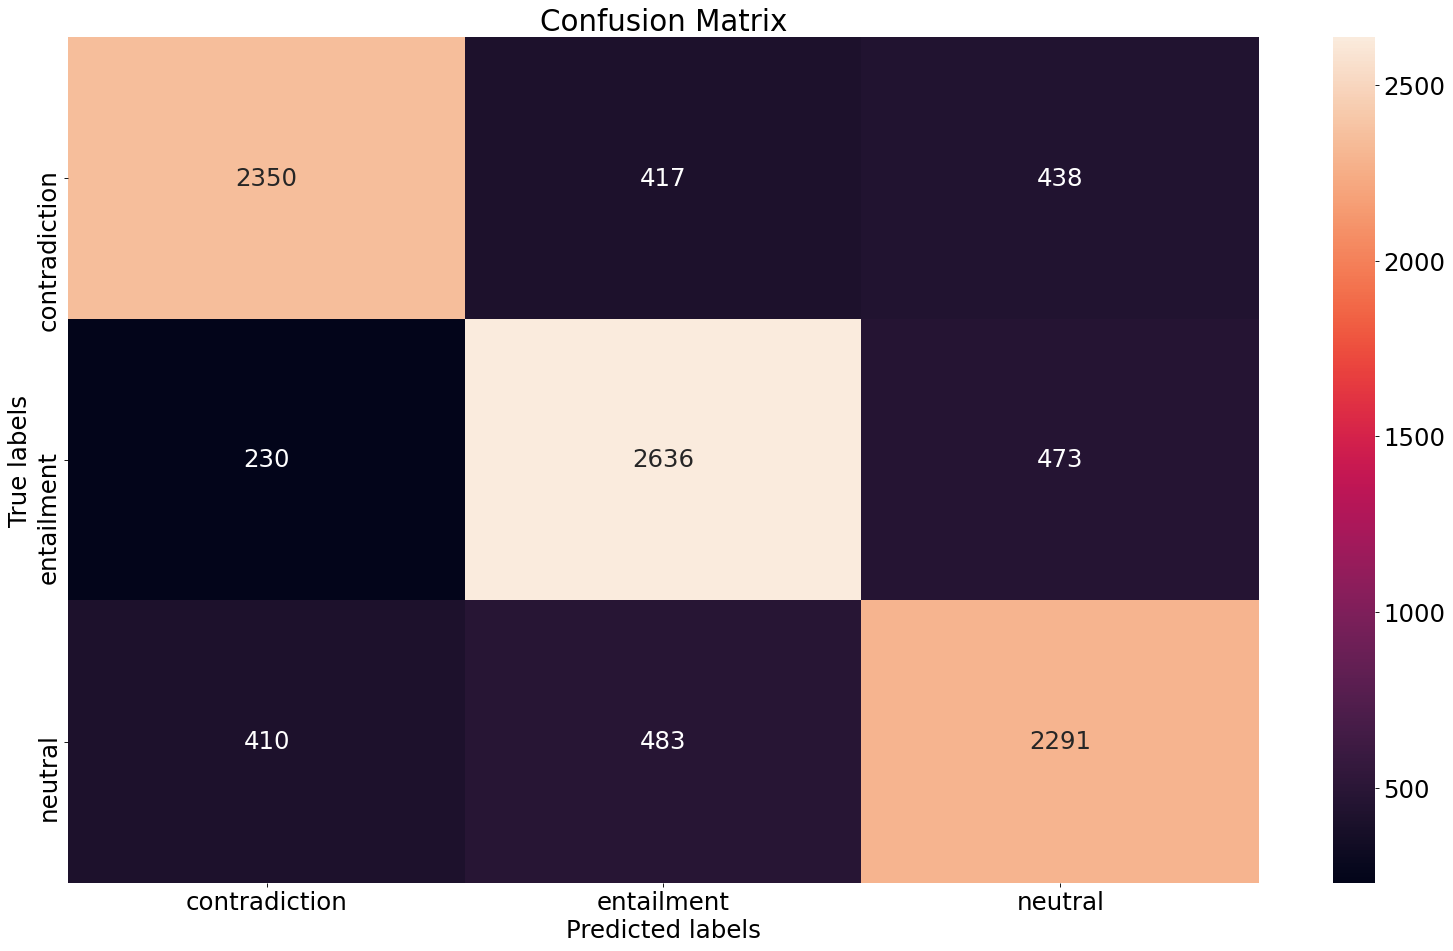

In [12]:
plt.rcParams.update({'font.size': 22})
labels = {'contradiction':0, 'entailment':1, 'neutral':2}
figure(figsize=(24, 14), dpi=80)
cm = confusion_matrix(outcomes['true_test'], outcomes['pred_test'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - teste')
ax.xaxis.set_ticklabels(labels.keys())
ax.yaxis.set_ticklabels(labels.keys())

In [24]:
critical = (cm[0,1] + cm[1,0])/cm.sum()
display(Markdown(f'The critical error: {critical*100} %'))

The critical error: 6.650904605263158 %

## Conclusão:

A partir da análise dos resultados e da visualização da matriz de confusão é possível concluir que o desempenho é satisfatório. A acurácia de teste de 74.75% é satisfatória devido a tarefa que estamos resolvendo. Assim como foi discutido na introdução, existe uma ambiguidade intrínseca ao problema que o torna bem desafiador. 
No próprio site de Stanford, em que eles disponibilizam o dataset (https://nlp.stanford.edu/projects/snli/) existe uma lista de métodos que se propõe a resolver o problema em questão. É possível notar que os melhores (estado da arte) usam mecanismos de atenção e possuem mais de 300 milhões de parâmetros. Infelizmente não dá para comparar esses métodos com o proposto neste trabalho, uma vez que usam uma quantidade enorme de parâmetros e o treinamento não é muito simples.  É possível notar que a grande maioria dos trabalhos para esse problema usam mecanismos de atenção, o que é um indício que realmente essa técnica ajuda muito no desempenho da tarefa. 

Além do mais o objetivo deste trabalho não é bater o estado da arte e sim adquirir um aprendizado consistente sobre NLP. 

Diante disso, escolhemos comparar o nosso método com nosso método, modelos que não usam técnica de atenção e que tenha uma quantidade razoável de parâmetros.  A partir disso, escolhemos os trabalhos de Bowman et al. '16 e Munkhdalai & Yu '16a. que ambos possuem 3 milhões e são baseados em LSTM. 
O trabalho de Bowman et al. '16, usa um modelo de linguagem com vetores de tamanho 300, assim como o nosso trabalho. Esse trabalho atingiu uma acurácia de treino de 83 %, que foi muito próximo ao nosso resultado (82%). Entretanto esse trabalho atingiu uma acurácia de teste de 80% que foi superior à nossa (74%).  Um principal motivo é a que de fato essa metodologia é mais robusta.  
 Esse trabalho propõe o modelo Stack-augmented Parser-Interpreter Neural Network que cria um modelo de inter-relação para cada sequência de entrada, assim consegue representar melhor a sequência de uma forma mais discriminativa.

Já o trabalho  Munkhdalai & Yu '16ª propõe uma metodologia bem inovadora que permute uma acesso múltiplo de memoria de outras representações no espaço escondido referente a cada palavra, fazendo com que possa realizar cálculos com as representações de cada palavra de forma dinâmica. Esse trabalho apresentou um resultado de treino de 86 % e de teste de 84%. 
Em suma, o trabalho proposto apresenta um resultado nos dados de treino muito bons, ao se comparar com os artigos discutidos anteriormente. Entretanto o nosso método peca na generalização, visto que não tem um desempenho tão bom nos dados de teste. Realmente seria necessário mais estudo e conhecimento especializado para se atingir um desempenho superior para que se possa comparar com os trabalhos discutidos. 
O resultado foi bem interessante e o objetivo de aprendizado foi atingido. Foi muito interessante entender a montagem do dataset e a criação do modelo em si. Agregou muito ao meu aprendizado. 






